<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_16_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Ultra Pro.
Создайте Seq2Seq сеть для предсказания временного ряда. Можно воспользоваться любым временным рядом из предыдущих заданий или создать его самостоятельно

Воспользуемся временным рядом: **Прогнозирование курса акций Лукойл**

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Model

# Основные слои
from tensorflow.keras.layers import Input, Dense, LSTM

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import MinMaxScaler 

from tensorflow.keras.utils import plot_model

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

Загрузим данные акций за 16-17 года и 18-19 года:

In [2]:
# Загрузка датасетов из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

Переведем данные в DataFrame:

In [3]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('18_19.csv', sep=';')

Посмотрим содержимое таблицы и выведем пример нулевой строки:

In [4]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


Изучив содержимое таблиц, снова их подгрузим, но уже сразу удалим ненужные столбцы по дате и времени:

In [5]:
# Пример данных из нулевой строки
print(base_data.values[0])

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [6]:
# Чтение данных в таблицы с удалением ненужных столбцов
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

Объединим таблицы в одну общую:

In [7]:
# Создание общего набора данных из двух датасетов
data_full = pd.concat([data16_17, data18_19]).to_numpy()

### Подготовка выборок данных для нейросети




In [8]:
# выбор колонок для обучения
data = data_full

# нормализация данных
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)

Определим гиперпараметры:

In [9]:
# гиперпараметры
num_encoder_tokens = 5 # число входных переменных
num_decoder_tokens = 1 # число выходных переменных
latent_dim = 256 # размерность скрытого слоя
num_steps = 10 # количество временных шагов
batch_size = 32 # размер батча
epochs = 50 # количество эпох

Подготовим данные для обучения и тестирования. Мы будем использовать первые 70% данных для обучения и оставшиеся 30% для тестирования:

In [10]:
# определение размеров обучающего и тестового наборов
train_size = int(0.7 * len(data_norm))
test_size = len(data_norm) - train_size

# разделение на обучающий и тестовый наборы
train_data = data_norm[:train_size]
test_data = data_norm[train_size:]

# определение входных и выходных переменных для обучающего набора
train_x = np.zeros((train_size - num_steps, num_steps, num_encoder_tokens))
train_y = np.zeros((train_size - num_steps, num_decoder_tokens))

for i in range(num_steps):
    train_x[:, i, :] = np.roll(train_data, -i, axis=0)[:train_size-num_steps, :num_encoder_tokens]
    train_y[:, 0] = np.roll(train_data[:, -1], -num_steps, axis=0)[:train_size-num_steps]

# определение входных и выходных переменных для тестового набора
test_x = np.zeros((test_size - num_steps, num_steps, num_encoder_tokens))
test_y = np.zeros((test_size - num_steps, num_decoder_tokens))

for i in range(num_steps):
    test_x[:, i, :] = np.roll(test_data, -i, axis=0)[:test_size-num_steps, :num_encoder_tokens]
    test_y[:, 0] = np.roll(test_data[:, -1], -num_steps, axis=0)[:test_size-num_steps]


Определим Seq2Seq модель, она будет состоять из кодера и декодера:

In [11]:
# определение модели
encoder_inputs = Input(shape=(num_steps, num_encoder_tokens))
encoder_lstm1 = LSTM(latent_dim, return_sequences=True)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True)
encoder_lstm3 = LSTM(latent_dim, return_state=True)
encoder_outputs = encoder_lstm3(encoder_lstm2(encoder_lstm1(encoder_inputs)))
state_h, state_c = encoder_outputs[1], encoder_outputs[2]
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(1, num_decoder_tokens))
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm3(decoder_lstm2(decoder_lstm1(decoder_inputs, initial_state=encoder_states)))
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# компиляция модели
model.compile(optimizer='adam', loss='mse')

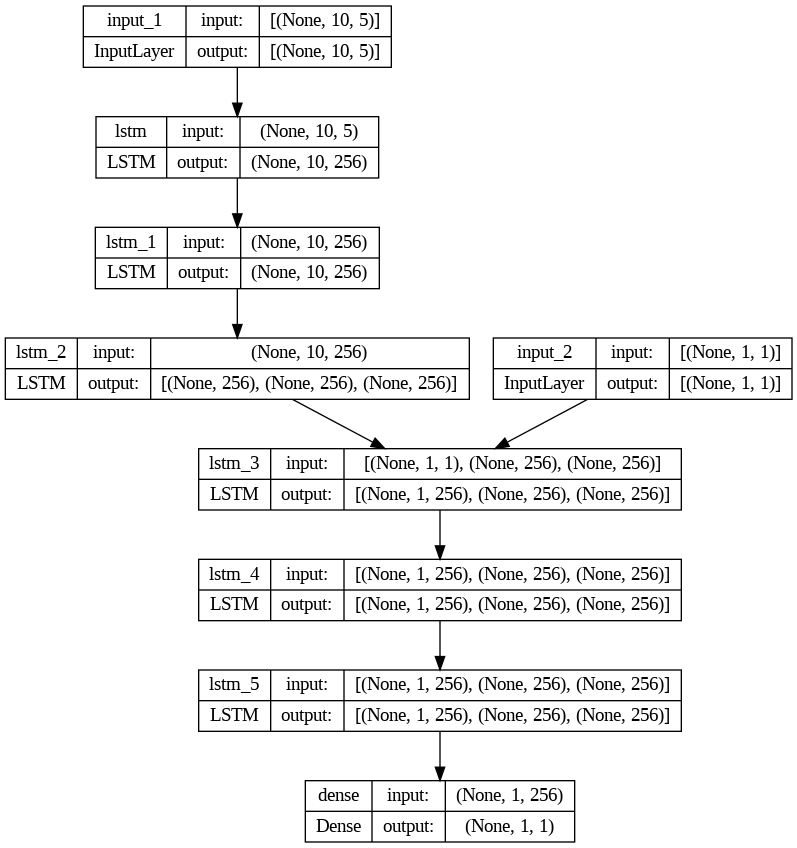

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

Обучим модель:

In [13]:
# обучение модели
history = model.fit([test_x, test_y], test_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
3614/3614 [==============================] - 62s 14ms/step - loss: 1.9489e-04 - val_loss: 1.4712e-06
Epoch 2/50
3614/3614 [==============================] - 49s 14ms/step - loss: 1.6012e-05 - val_loss: 1.4712e-06
Epoch 3/50
3614/3614 [==============================] - 48s 13ms/step - loss: 1.6012e-05 - val_loss: 1.4712e-06
Epoch 4/50
3614/3614 [==============================] - 48s 13ms/step - loss: 1.6012e-05 - val_loss: 1.4712e-06
Epoch 5/50
3614/3614 [==============================] - 48s 13ms/step - loss: 1.6012e-05 - val_loss: 1.4712e-06
Epoch 6/50
3614/3614 [==============================] - 49s 13ms/step - loss: 1.6012e-05 - val_loss: 1.4712e-06
Epoch 7/50
3614/3614 [==============================] - 47s 13ms/step - loss: 1.6012e-05 - val_loss: 1.4707e-06
Epoch 8/50
3614/3614 [==============================] - 48s 13ms/step - loss: 1.5939e-05 - val_loss: 1.3452e-06
Epoch 9/50
3614/3614 [==============================] - 48s 13ms/step - loss: 1.5901e-05 - val_loss: 1.3

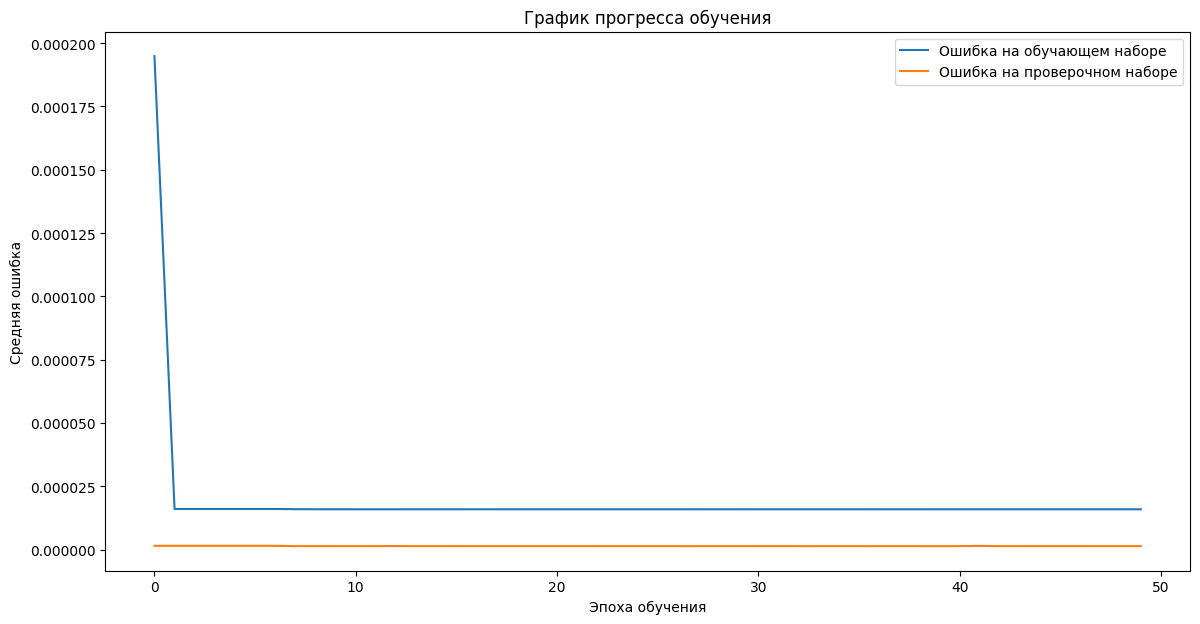

In [14]:
# Рисование графиков прошедшей фазы обучения
fig = plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.title(f'График прогресса обучения')
# Указание показывать только целые метки шкалы оси x
fig.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Используем модель для предсказания значений на тестовом наборе:

In [15]:
# использование модели для предсказания значений на тестовом наборе
predictions = model.predict([test_x, np.zeros((test_size - num_steps, 1, num_decoder_tokens))])

4518/4518 [==============================] - 26s 5ms/step


In [16]:
test_data_denorm = data_full[train_size:]
test_y_denorm = np.zeros((test_size - num_steps, num_decoder_tokens))

for i in range(num_steps):
    test_y_denorm[:, 0] = np.roll(test_data_denorm[:, -1], -num_steps, axis=0)[:test_size-num_steps]

y_scaler = MinMaxScaler()
test_y_norm = y_scaler.fit_transform(test_y_denorm)

# денормализация предсказанных значений
predictions_denorm = y_scaler.inverse_transform( predictions.reshape(predictions.size,1))

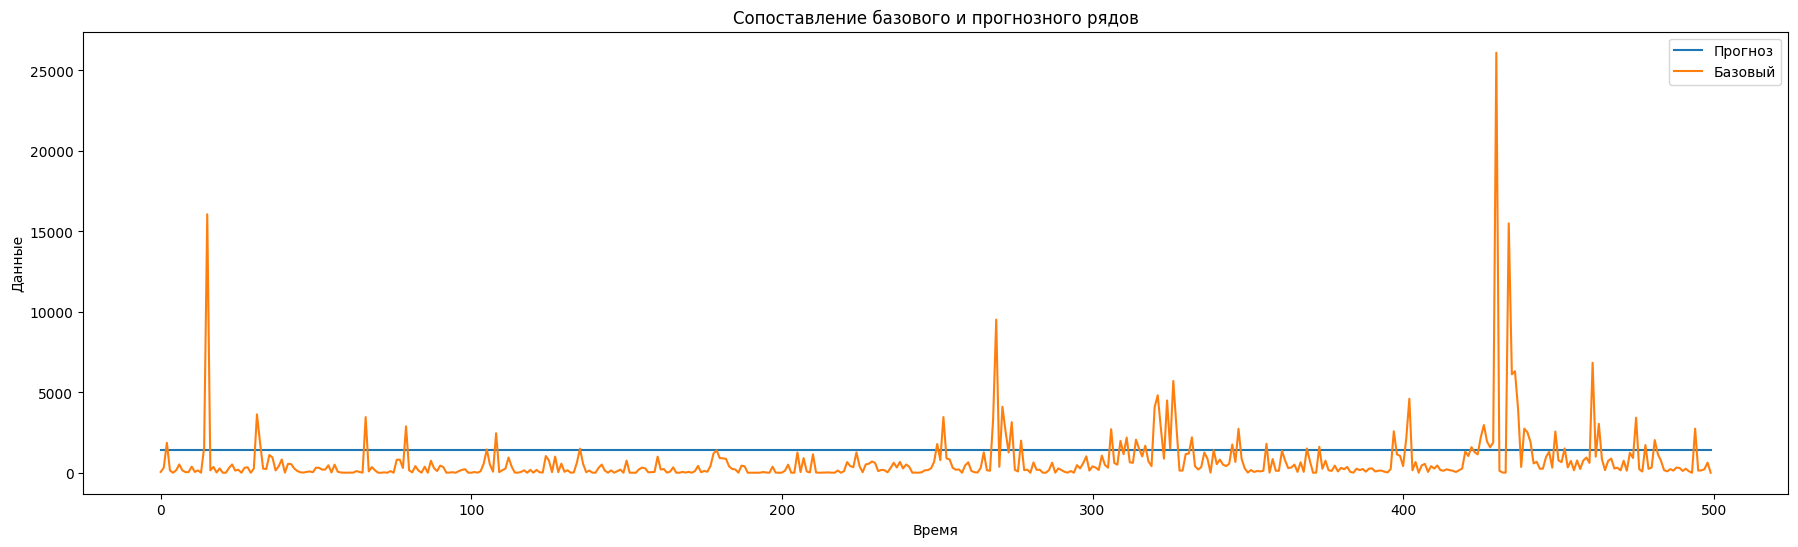

In [17]:
# Построение графика по всем каналам данных
plt.figure(figsize=(22, 6))

start = 0
length = 500

plt.plot(predictions_denorm[start:start + length], label=f'Прогноз')
plt.plot(test_y_denorm[start:start + length], label=f'Базовый')

plt.title('Сопоставление базового и прогнозного рядов')
plt.xlabel('Время')
plt.ylabel('Данные')
plt.legend()
plt.show()